# 初めてのグラフ理論からDNA塩基配列決定まで (Jijのサービスを用いてハミルトン経路問題を解く)

## ハミルトン経路問題

### 概要

頂点数が$N$のグラフ$G=(V, E)$が与えられたとしましょう。ここで$V$は頂点の集合、$E$は辺の集合を表します。ある頂点から出発し、辺に沿って移動してグラフ内の頂点を訪れるとき、訪れた頂点に2度と戻らないようにグラフ内の全ての頂点に到達することは可能かどうかを調べる問題です。要するに一筆書きができるかどうかを判定します。この問題では有向(道路の一方通行のように、ある辺を移動するのに向きを守らなければならない)グラフ・無向グラフのどちらでも考えることができます。

この問題はNP完全であることが知られています。

また、上述に加えて最後に出発点に戻ってくるような経路が存在するかどうかを調べる問題をハミルトン閉路問題と呼びます。

### 応用: DNAの塩基配列を決定する

DNAはアデニン(A), グアニン(G), シトシン(C), チミン(T)の4種類の塩基順列で構成されています。長いDNAの鎖の端から端までを正確に切れ目なく1塩基単位で読み取る手法は今のところ存在しないため、何らかの手法でこれを小さな断片に裁断します。このとき、分割された断片は前後の断片とある程度の長さの共通部分を持っています。この小断片たちから、元の塩基配列を決定してみましょう。

- $S_1$: TCTTA
- $S_2$: CGTCT
- $S_3$: CTTACA
- $S_4$: ACCGT
- $S_5$: CATGG

上のリストのようにあるDNAが5個の断片$S_1, \dots, S_5$に分割されたとします。このとき$S_1$の最初の3文字と$S_2$の最後の3文字がともにTCTで一致しているため、$S_2$の直後に$S_1$が配置できることがわかります。これをグラフで表現し、$S_2$と$S_1$を辺で結びましょう。ただし、$S_1$の直後には$S_2$は配置できないため、ここでは向きが付けられた辺(有向辺)で$S_2 \rightarrow S_1$のように結ぶことにします。同様にして他の断片についてもその関係性を有向辺で結んでいくと、下図のようになることがわかります。

![ハミルトン経路によるDNA解析](./images/hamilton_path_01.png)

よってこの断片たちが作られた元々のDNA塩基配列が知りたければ、上のグラフのハミルトン経路問題を解けば良いことがわかります。このようにしてDNA塩基配列を求める手法を全ゲノムショットガン法と呼びます。  
上図は簡単な場合でしたが、頂点数や辺の数が多数存在する場合に、全ての頂点を1度訪れるような一筆書きのなぞり方はどのように求めることができるでしょうか。今回はハミルトン経路問題の数理モデル立案・QUBO定式化を行い、それをJijのプロダクトで解いてみましょう。

## 数理モデル立案

### バイナリ変数

今回は頂点$v$を$i$番目に訪れるとき$x_{v, i}=1$, それ以外の場合は$x_{v, i}=0$となるようなバイナリ変数$x_{v, i}$を用いましょう。

### 制約1: 1つ頂点を訪れることができるのは1回のみ

問題から、1つの頂点を訪れることができるのは1回だけです。これを数式で表現すると以下のようになります。

$$
\sum_{i=0}^{N-1} x_{v, i} = 1 \quad(\forall v) \tag{1}
$$

これは頂点$v$(場所)に対するone-hot制約です。

### 制約2: $i$番目に訪れることができる頂点は1ヶ所のみ

先ほどと同様の考え方で、この制約は以下のように数式で表現できます。

$$
\sum_{v=0}^{N-1} x_{v, i} = 1 \quad (\forall i) \tag{2}
$$

これは$i$番目に訪れること(時間)に対するone-hot制約です。

### 制約3: 存在しない辺の移動は許されない

この問題では、グラフの辺が存在しない移動をしてはいけません。これは以下のように考えることができます。

- $i$番目に訪れる頂点$u$と$i+1$番目に訪れる頂点$v$を結ぶ辺が存在するとき、$x_{u, i} x_{v, i+1} = 1 \ (x_{u, i}= x_{v, i+1}=1)$が許される
- $i$番目に訪れる頂点$u$と$i+1$番目に訪れる頂点$v$を結ぶ辺が存在しないとき、$x_{u, i} x_{v, i+1} = 0 \ (x_{u, i}=0 \ \mathrm{or} \ x_{v, i+1}=0)$でなければならない

よってこの制約は以下のようになります。

$$
\sum_{(uv) \notin E} x_{u, i} x_{v, i+1}=0 \quad (i= 0, 1, \dots, N-2)\tag{3}
$$

$i$の取り得る範囲が$N-2$までとなっているのは、$N-1$回の移動を表すためです。

## 実装しましょう

それでは実際にJijのプロダクトを用いて、この問題を解くためのPythonスクリプトを作成しましょう。

### 問題の作成・初期化

In [5]:
import jijmodeling as jm

# set problem
problem = jm.Problem('hamilton_path')

### 変数の定義

以下のようにして、種々の変数を定義します。

In [6]:
# define variables
N = jm.Placeholder('N')
no_E = jm.Placeholder('no_E', dim=2)
x = jm.Binary('x', shape=(N, N))
i = jm.Element('i', (0, N))
v = jm.Element('v', (0, N))
e = jm.Element('e', no_E)

`N`はグラフの頂点の総数です。`no_E`は辺が結ばれていない部分の集合を表す変数です($\mathrm{no\_E} \notin E$)。例えば頂点(0, 1), (3, 5)に辺がない場合、[[0, 1], [3, 5]]のような2次元配列としてこれが表現されます。`e`は辺を表す2次元配列の変数列です。先ほどの`no_E`の集合の範囲の値をとること、すなわち$e \in \mathrm{no\_E}$を上述のように一行で書くことができます。

### 制約の実装

(1)式を実装しましょう。

In [7]:
# set one-hot constraint for each vertices
const = x[v, :]
problem += jm.Constraint('h1', const==1, forall=v)

$\sum_i x_{v, i}$を`x[v, :]`で表現しています。  
同様に(2)式は

In [8]:
# set one-hot constraint for each time
const = x[:, i]
problem += jm.Constraint('h2', const==1, forall=i)

のように実装されます。  
そして(3)式は以下のように記述されます。

In [9]:
# set constraint for moving without edges
const = jm.Sum(e, x[e[0], i]*x[e[1], i+1])
problem += jm.Constraint('h3', const==0, forall=[(i, i<N-1)])

事前に定義指定おいた`e = jm.Element('e', no_E)`を用いて`jm.Sum(e, ...)`とすることで、$\sum_{e \in \mathrm{no\_E}} (= \sum_{e \notin E})$を表現しています。`e[0]`, `e[1]`はそれぞれ結ばれていない辺(uv)の頂点u, vを表します。先ほど`jm.Element`で定義した`i`を用いて、`i+1`番目との添字との関係を記述しています。

### インスタンスの作成

実際にハミルトン経路問題を解きたいグラフを、問題に与えることにしましょう。

In [10]:
from itertools import permutations
import networkx as nx

# set the number of vertices
inst_N = 6
# create a random graph
inst_G = nx.gnp_random_graph(inst_N, 0.5, directed=True)
# get information of edges
inst_E = inst_G.edges
# make no edges list
inst_no_E = permutations(range(inst_N), 2)
inst_no_E = set(inst_no_E) - set(inst_E)
inst_no_E = [list(edge) for edge in inst_no_E]
instance_data = {'N': inst_N, 'no_E': inst_no_E}

上のスクリプトでは、頂点数6でランダムに辺を結んだ有向グラフを作成します。先ほどの定式化から、用いるのは辺が結ばれていない部分であるため、それを抽出する作業を行なっています。これを`JijZept`を用いて計算するために、頂点数と結ばれていない辺の集合を辞書に格納しています。

### 未定乗数の決定

この問題には3つの制約が存在するため、それらの未定乗数を設定しましょう。以下では3つとも1としています。

In [11]:
# set multipliers
lam1 = 1.0
lam2 = 1.0
lam3 = 1.0
multipliers = {'h1': lam1, 'h2': lam2, 'h3': lam3}

### JijZeptで問題を解く

それでは`JijZept`のSAを用いて、この問題の最適解を求めます。

In [13]:
import jijzept as jz

# set sampler
sampler = jz.JijSASampler(config='./config.toml')
# solve problem
response = sampler.sample_model(problem, instance_data, multipliers, 
                                num_reads=100, num_sweeps=100)

uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is 4b456b544750461f9e1fd28b8fcea11a.
running...


### 解析しやすくする

出てきた結果を解析しやすくするために、decodeを行いましょう。

In [14]:
# decode solution
decoded = problem.decode(response, instance_data, {})

### 結果の可視化

エネルギーが一番低い解だけを取り出し、その解がどのようなものかを見てみましょう。

{'h1': 0.0, 'h2': 0.0, 'h3': 0.0}
[[0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]


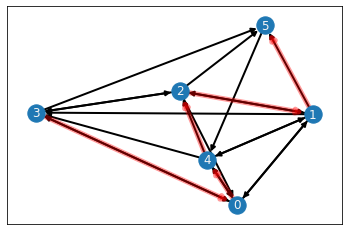

In [19]:
import matplotlib.pyplot as plt

x = decoded.solutions[0]['x']
penalty = decoded.constraint_violations[0]
print(penalty)
x = x.T
print(x)
edge_list = []
for i in range(len(x)-1):
    i_sol = list(x[i])
    ip1_sol = list(x[i+1])
    edge = (i_sol.index(1), ip1_sol.index(1))
    edge_list.append(edge)
vis_G = nx.DiGraph()
vis_G.add_edges_from(inst_E)
pos = nx.spring_layout(vis_G)
nx.draw_networkx(vis_G, pos, arrows=True, width=2, with_labels=True, font_color='whitesmoke', arrowstyle='-|>')
nx.draw_networkx_edges(vis_G, pos, edgelist=edge_list, width=5, edge_color='r', alpha=0.4)
plt.show()

一筆書きのハミルトン経路が選ばれていることがわかります。

# 結言

今回はDNA塩基配列決定にも使われるハミルトン経路問題を題材に、JijModelingとJijZeptの使い方をご紹介しました。今回新しく登場したテクニックを以下にまとめます。

- e=jm.Element('e', no_E)のように、$e \in \mathrm{no\_E}$のような集合を簡単に記述することができる。
- さらにjm.Sum(e, ...)のようにすることで、先ほど定義した集合を用いた$\sum_{e \in \mathrm{no\_E}}$のような総和を簡単に記述することができる。

「数式を紙に書くようにスクリプトを記述する」ことができるJijModelingを用いて、難しい最適化問題をどんどん定式化していきましょう。

# 参考文献

[1] [Lucas, 2013, "Ising formulations of many NP problems"](https://www.frontiersin.org/articles/10.3389/fphy.2014.00005/full)  
[2] [Boev et al., 2012, "Genome assembly using quantum and quantum-inspired annealing"](https://doi.org/10.1038/s41598-021-88321-5)